In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
import numpy as np
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.preprocessing import image                  

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import regularizers
from tqdm import tqdm
import pandas as pd
import random

Using TensorFlow backend.
C:\Users\najib\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\najib\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\najib\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\najib\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2                                     
%matplotlib inline         

In [3]:
# from sklearn.datasets import load_files       
# from keras.utils import np_utils
# import numpy as np
# from glob import glob
# import pandas as pd
# import matplotlib.pyplot as plt

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
dog_breeds = len(dog_names)

In [4]:
def class_graph(loc):
    list_names = []
    num_files = []
    dog_db = pd.DataFrame()

    for  folder in sorted(glob("dogImages/"+loc+"/*/")):
        list_names.append(folder[20:-1])
        num_files.append(len(folder))    
    dog_db['breed_name'] = list_names
    dog_db['num_images'] = num_files
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.bar(list_names,num_files)
    plt.show()
    return dog_db

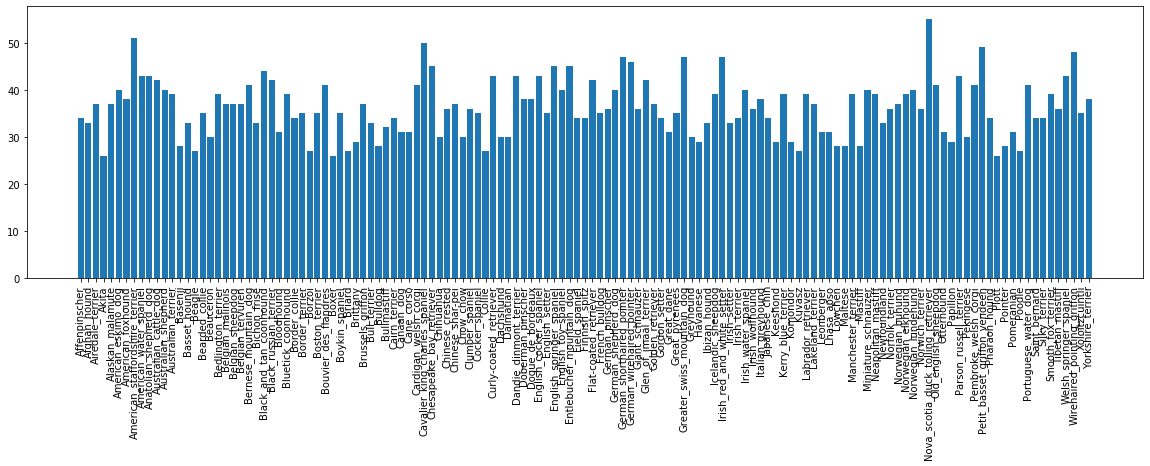

,breed_name,num_images
0,Affenpinscher,34
1,Afghan_hound,33
2,Airedale_terrier,37
3,Akita,26
4,Alaskan_malamute,37
...,...,...
128,Tibetan_mastiff,36
129,Welsh_springer_spaniel,43
130,Wirehaired_pointing_griffon,48
131,Xoloitzcuintli,35


In [5]:
class_graph('train')

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [9]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [10]:
ht=[]
wd=[]
for i in range(0,len(train_files)):
    img = cv2.imread(train_files[i])
    height, width, channels = img.shape 
    ht.append(height)
    wd.append(width)


Text(0, 0.5, 'Width')

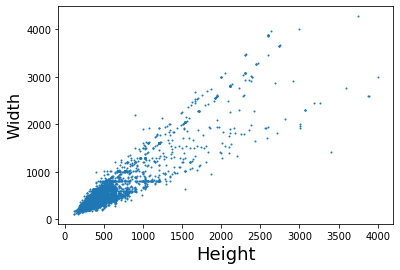

In [11]:
plt.scatter(ht,wd, s=1)
plt.xlabel('Height', fontsize=18)
plt.ylabel('Width', fontsize=16)

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

 28%|██████████████████████▏                                                       | 1902/6680 [00:49<02:07, 37.39it/s]

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(8, kernel_size=(2), activation='relu', input_shape=( 224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 20), strides=(2, 2)))
model.add(Conv2D(16, kernel_size=(2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 20), strides=(2, 2)))
model.add(Conv2D(32, kernel_size=(2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 20), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=(2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 10), strides=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 8)       104       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 102, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 101, 16)      528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 41, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 40, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 11, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 10, 64)        8256      
__________

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

historyV = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [ ]:

dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
# summarize history for accuracy
plt.plot(historyV.history['acc'])
plt.plot(historyV.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyV.history['loss'])
plt.plot(historyV.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
bottleneck_features = np.load('bottleneck_features\\DogVGG19Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

historyV = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [ ]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
# summarize history for accuracy
plt.plot(historyV.history['acc'])
plt.plot(historyV.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyV.history['loss'])
plt.plot(historyV.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [17]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [18]:
InceptionV3_model = Sequential()

InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dropout(0.5))

InceptionV3_model.add(Dense(133, activation='softmax'))


InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [19]:
   
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [20]:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

history = InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 5s 726us/step - loss: 1.5588 - acc: 0.6213 - val_loss: 0.6151 - val_acc: 0.8108

Epoch 00001: val_loss improved from inf to 0.61509, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/50
6680/6680 [==============================] - 2s 369us/step - loss: 0.6518 - acc: 0.8112 - val_loss: 0.6361 - val_acc: 0.8192

Epoch 00002: val_loss did not improve from 0.61509
Epoch 3/50
6680/6680 [==============================] - 2s 367us/step - loss: 0.5325 - acc: 0.8493 - val_loss: 0.6034 - val_acc: 0.8359

Epoch 00003: val_loss improved from 0.61509 to 0.60338, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 4/50
6680/6680 [==============================] - 2s 370us/step - loss: 0.5101 - acc: 0.8608 - val_loss: 0.6609 - val_acc: 0.8467

Epoch 00004: val_loss did not improve from 0.60338
Epoch 5/50
6680/6680 [==============================] - 2s 367us/step - loss:

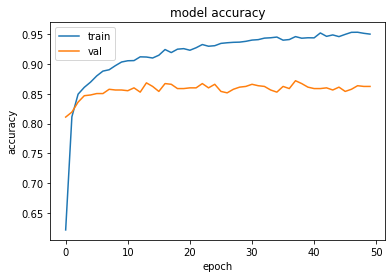

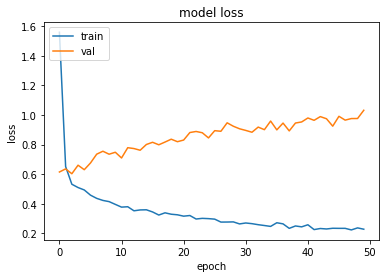

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [23]:

InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.3828%


In [51]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [52]:
InceptionV3_model = Sequential()

InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(16, activation='relu'))

InceptionV3_model.add(Dropout(0.5))   #this helps accuracy a little bit

InceptionV3_model.add(Dense(133, activation='softmax'))


InceptionV3_model.summary()

#relu activation is 9% accuracy!, sigmoid is worse

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                32784     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               2261      
Total params: 35,045
Trainable params: 35,045
Non-trainable params: 0
_________________________________________________________________


In [53]:
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [54]:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

history = InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 4s 601us/step - loss: 4.4062 - acc: 0.0603 - val_loss: 3.4397 - val_acc: 0.3222

Epoch 00001: val_loss improved from inf to 3.43970, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/50
6680/6680 [==============================] - 3s 415us/step - loss: 3.5507 - acc: 0.1584 - val_loss: 2.3296 - val_acc: 0.5329

Epoch 00002: val_loss improved from 3.43970 to 2.32964, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 3/50
6680/6680 [==============================] - 3s 409us/step - loss: 3.1793 - acc: 0.2030 - val_loss: 1.8812 - val_acc: 0.6144

Epoch 00003: val_loss improved from 2.32964 to 1.88124, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 4/50
6680/6680 [==============================] - 3s 416us/step - loss: 2.9854 - acc: 0.2308 - val_loss: 1.6859 - val_acc: 0.6419

Epoch 00004: val_loss improved from 1.88124 to 1.68594, saving m

6680/6680 [==============================] - 3s 431us/step - loss: 2.3776 - acc: 0.3286 - val_loss: 1.5231 - val_acc: 0.6335

Epoch 00040: val_loss did not improve from 1.16622
Epoch 41/50
6680/6680 [==============================] - 3s 432us/step - loss: 2.3676 - acc: 0.3376 - val_loss: 1.2930 - val_acc: 0.6874

Epoch 00041: val_loss did not improve from 1.16622
Epoch 42/50
6680/6680 [==============================] - 3s 427us/step - loss: 2.3767 - acc: 0.3317 - val_loss: 1.3124 - val_acc: 0.6946

Epoch 00042: val_loss did not improve from 1.16622
Epoch 43/50
6680/6680 [==============================] - 3s 424us/step - loss: 2.3800 - acc: 0.3292 - val_loss: 1.3062 - val_acc: 0.6862

Epoch 00043: val_loss did not improve from 1.16622
Epoch 44/50
6680/6680 [==============================] - 3s 413us/step - loss: 2.3574 - acc: 0.3397 - val_loss: 1.3821 - val_acc: 0.6731

Epoch 00044: val_loss did not improve from 1.16622
Epoch 45/50
6680/6680 [==============================] - 3s 405us/s

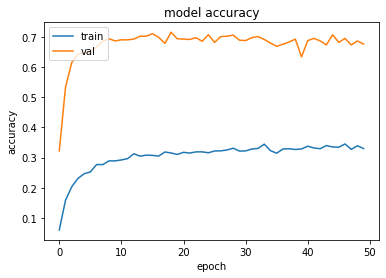

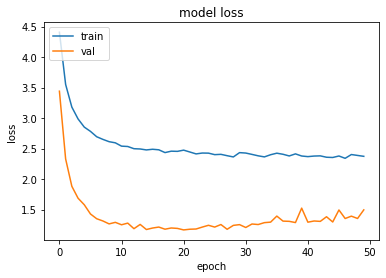

In [56]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 67.4641%
